# Multi-label Land Cover Classification with BigEarthNet

## 2020년 08월 31일 안상호

---

# Requirement

In [21]:
from pathlib import Path

# Sangho Workspace|
root_dir = Path("/home/jovyan/")
base_dir = root_dir  / 'Land-Cls'

data_path = base_dir / "data" 

In [22]:
import sys
import os

# Google Colab Version
# sys.path.append(str(base_dir))


# Local Version
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser("__file__"))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

In [23]:
!pip3 install "torch==1.4" "torchvision==0.5.0"


In [24]:
from fastai.vision import *
from fastai.metrics import error_rate

# 1. 기초 학습

## 1.1. DataBunch

In [5]:
bigearth_path = data_path / "bigearth"
output_path = bigearth_path / "train-labels.csv"

cloud_shadow_path = bigearth_path / "patches_with_cloud_and_shadow.csv"
snow_path = bigearth_path / "patches_with_seasonal_snow.csv"

In [6]:
files = os.listdir(bigearth_path / "BigEarthNet-v1.0")
len(files)

590326

In [26]:
class_df = pd.read_csv(output_path)
# data_exist = class_df.image_name.apply(lambda x: x + ".jpg" in fnames)
# print(data_exist.shape)
# data_exist.head()

print(class_df.shape)
class_df.head()

(590326, 2)


,image_name,label
0,S2A_MSIL2A_20180508T104031_26_63.jpg,Non-irrigated arable land;Pastures;Land princi...
1,S2A_MSIL2A_20180318T093031_50_50.jpg,Non-irrigated arable land;Pastures;Complex cul...
2,S2A_MSIL2A_20171002T112112_74_52.jpg,"Land principally occupied by agriculture, with..."
3,S2B_MSIL2A_20180204T94161_76_26.jpg,Coniferous forest;Mixed forest;Transitional wo...
4,S2A_MSIL2A_20171015T095031_26_65.jpg,Discontinuous urban fabric;Non-irrigated arabl...


In [27]:
cloud_df = pd.read_csv(cloud_shadow_path, header=None).apply(lambda x: x + ".jpg")
snow_df = pd.read_csv(snow_path, header=None).apply(lambda x: x + ".jpg")

cloud_df.shape, snow_df.shape


((9280, 1), (61707, 1))

In [28]:
cloud_mask = class_df["image_name"].isin(cloud_df[0]) 
snow_mask = class_df["image_name"].isin(snow_df[0])

In [29]:
class_df = class_df[~(cloud_mask | snow_mask)]
class_df

,image_name,label
0,S2A_MSIL2A_20180508T104031_26_63.jpg,Non-irrigated arable land;Pastures;Land princi...
1,S2A_MSIL2A_20180318T093031_50_50.jpg,Non-irrigated arable land;Pastures;Complex cul...
2,S2A_MSIL2A_20171002T112112_74_52.jpg,"Land principally occupied by agriculture, with..."
4,S2A_MSIL2A_20171015T095031_26_65.jpg,Discontinuous urban fabric;Non-irrigated arabl...
5,S2B_MSIL2A_20170927T094019_7_19.jpg,Non-irrigated arable land;Complex cultivation ...
...,...,...
590320,S2B_MSIL2A_20180225T105019_47_4.jpg,Discontinuous urban fabric;Sport and leisure f...
590321,S2B_MSIL2A_20180511T100029_87_84.jpg,Sea and ocean
590322,S2B_MSIL2A_20170808T094029_3_78.jpg,Non-irrigated arable land;Land principally occ...
590323,S2B_MSIL2A_20180525T94031_49_10.jpg,"Land principally occupied by agriculture, with..."


In [30]:
class_df.to_csv(bigearth_path / "train.csv", index=False)

- `DataBunch` 생성

In [31]:
train_df = pd.read_csv(bigearth_path / "train.csv")
train_df

,image_name,label
0,S2A_MSIL2A_20180508T104031_26_63.jpg,Non-irrigated arable land;Pastures;Land princi...
1,S2A_MSIL2A_20180318T093031_50_50.jpg,Non-irrigated arable land;Pastures;Complex cul...
2,S2A_MSIL2A_20171002T112112_74_52.jpg,"Land principally occupied by agriculture, with..."
3,S2A_MSIL2A_20171015T095031_26_65.jpg,Discontinuous urban fabric;Non-irrigated arabl...
4,S2B_MSIL2A_20170927T094019_7_19.jpg,Non-irrigated arable land;Complex cultivation ...
...,...,...
519334,S2B_MSIL2A_20180225T105019_47_4.jpg,Discontinuous urban fabric;Sport and leisure f...
519335,S2B_MSIL2A_20180511T100029_87_84.jpg,Sea and ocean
519336,S2B_MSIL2A_20170808T094029_3_78.jpg,Non-irrigated arable land;Land principally occ...
519337,S2B_MSIL2A_20180525T94031_49_10.jpg,"Land principally occupied by agriculture, with..."


In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = (ImageList.from_csv(bigearth_path, "train.csv", folder='image')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(label_delim=';'))

In [8]:
data = (src.transform(tfms, size=256)
        .databunch(bs=64, no_check=True).normalize(imagenet_stats))

/opt/conda/lib/python3.7/site-packages/fastai/vision/data.py:306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


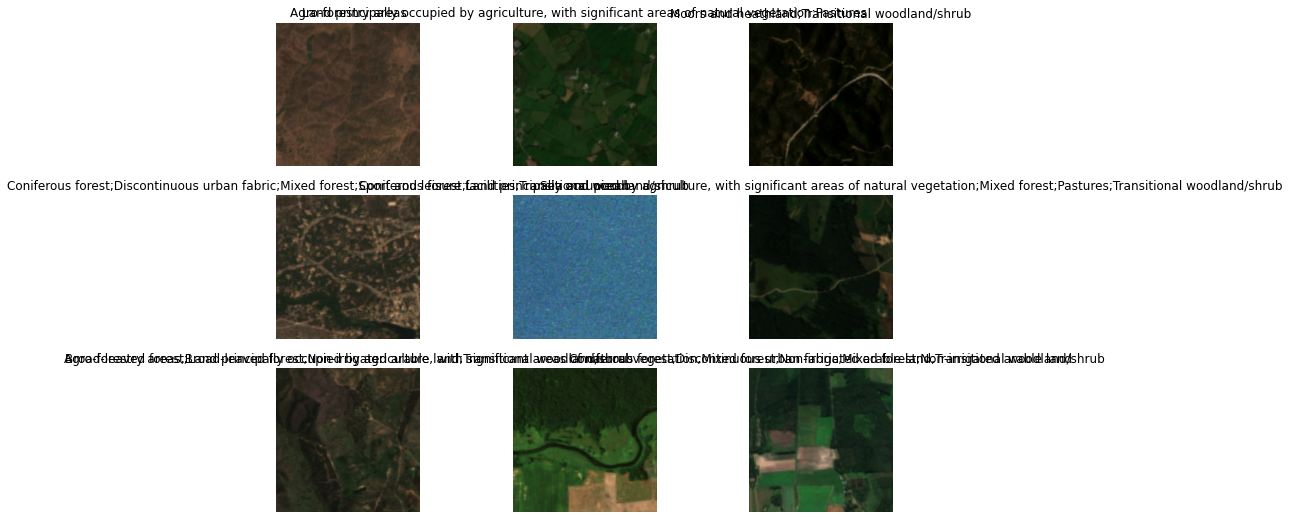

In [9]:
data.show_batch(rows=3, figsize=(12,9))

In [10]:
data.train_ds.y.classes, len(data.train_ds.y.classes)

(['Agro-forestry areas',
  'Airports',
  'Annual crops associated with permanent crops',
  'Bare rock',
  'Beaches, dunes, sands',
  'Broad-leaved forest',
  'Burnt areas',
  'Coastal lagoons',
  'Complex cultivation patterns',
  'Coniferous forest',
  'Construction sites',
  'Continuous urban fabric',
  'Discontinuous urban fabric',
  'Dump sites',
  'Estuaries',
  'Fruit trees and berry plantations',
  'Green urban areas',
  'Industrial or commercial units',
  'Inland marshes',
  'Intertidal flats',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Mineral extraction sites',
  'Mixed forest',
  'Moors and heathland',
  'Natural grassland',
  'Non-irrigated arable land',
  'Olive groves',
  'Pastures',
  'Peatbogs',
  'Permanently irrigated land',
  'Port areas',
  'Rice fields',
  'Road and rail networks and associated land',
  'Salines',
  'Salt marshes',
  'Sclerophyllous vegetation',
  'Sea and ocean',
  'Sparsely vegetated areas',
  'S

## 1.2. 모델 생성 및 학습

In [12]:
arch = models.resnet50

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


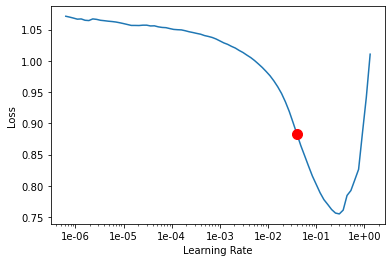

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, 5E-02)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


In [ ]:
learn.save(base_dir / "learn" / "bigearth-res50-test")

# 2. Architecture Selection



In [12]:
import torch
from sklearn.metrics import f1_score

@np_func
def f1_macro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='macro')

@np_func
def f1_weighted(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')


def create_multi_cls_learner(data, arch, threshold=0.2, pretrained=True):
    acc_02 = partial(accuracy_thresh, thresh=threshold)
    
    f1_score = partial(fbeta, thresh=threshold, beta=1)
    f2_score = partial(fbeta, thresh=threshold, beta=2)
    
    f1_score.__name__ = 'f1_score'
    f2_score.__name__ = 'f2_score'
    
    # f_score = partial(fbeta, thresh=threshold)
    learn = cnn_learner(data, arch, metrics=[acc_02, f1_score, f2_score], pretrained=pretrained)  
    learn.model = nn.DataParallel(learn.model)
    return learn
    

## 2.1. ResNet34

### With Pretraining

In [14]:
arch = models.resnet34

learn = create_multi_cls_learner(data, arch)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


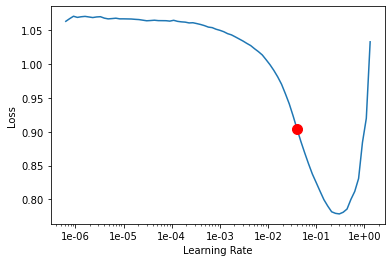

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(15, 5e-02)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.103789,0.096046,0.952301,0.778208,14:17
1,0.111428,0.110353,0.944881,0.739754,14:22
2,0.126457,14.271398,0.910522,0.571303,14:23
3,0.135717,0.985657,0.920387,0.687932,14:14
4,0.138071,0.861186,0.920290,0.698138,14:16
5,0.134349,1.527552,0.912466,0.539040,14:17
6,0.139380,0.164937,0.918343,0.660186,14:25
7,0.134568,2.321582,0.914962,0.574973,14:20
8,0.133205,0.367579,0.925435,0.672990,14:17
9,0.123678,0.672847,0.935829,0.728787,14:20


In [17]:
learn.save(base_dir / "learn" / "bigearth-res34-1")

- unfreeze, fine-tuning

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.98E-07


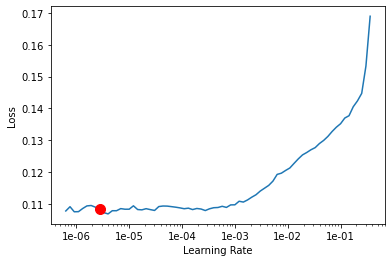

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Without Pretraining

## 2.2. ResNet50

### With Pretraining

In [44]:
arch = models.resnet50

learn = create_multi_cls_learner(data, arch)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 2.51E-02


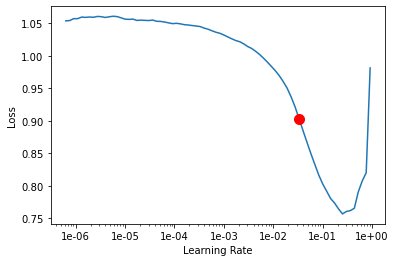

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
learn.fit_one_cycle(15, 5e-02)

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.101246,0.093581,0.947935,0.717609,0.785986,17:15
1,0.110126,0.101497,0.948392,0.714433,0.774370,17:18
2,0.121329,1.257625,0.929056,0.604721,0.657191,17:18
3,0.134158,0.676595,0.931351,0.636478,0.694603,17:16
4,0.132871,0.643354,0.906178,0.562002,0.663625,17:16
5,0.135362,0.208572,0.936828,0.634645,0.686709,17:14
6,0.134173,1.602971,0.920978,0.564647,0.596337,17:17
7,0.128471,0.567114,0.929380,0.627063,0.690890,17:15
8,0.132072,0.596386,0.928617,0.605645,0.664273,17:16
9,0.120183,0.261154,0.937672,0.650462,0.700514,17:16


In [46]:
learn.save(base_dir / "learn" / "bigearth-res50-1")

In [47]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 6.31E-08


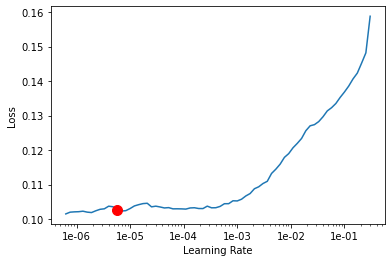

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 1e-03))
learn.save(base_dir / "learn" / "bigearth-res50-2")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.100128,0.102838,0.947937,0.717995,0.785283,21:25
1,0.103180,0.098872,0.946002,0.715667,0.790324,21:28
2,0.101425,0.100192,0.948052,0.721436,0.792221,21:27
3,0.100268,0.100463,0.949630,0.726416,0.793593,21:26
4,0.098139,0.096848,0.951240,0.731711,0.796228,21:22
5,0.095683,0.088398,0.950510,0.733410,0.803117,21:25
6,0.094576,0.087350,0.950567,0.734752,0.803874,21:24
7,0.094777,0.086633,0.952054,0.740272,0.805920,21:26
8,0.093904,0.086746,0.952042,0.739720,0.806860,21:26
9,0.094900,0.086144,0.952131,0.741014,0.808118,21:25


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Without Pretraining

In [13]:
arch = models.resnet50

learn = create_multi_cls_learner(data, arch, pretrained=False)

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.51E-02


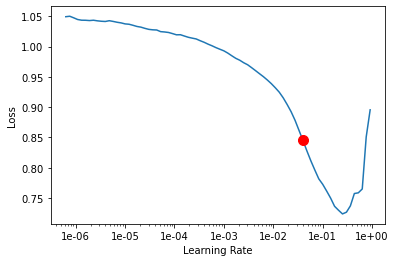

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(15, 5e-02)
learn.save(base_dir / "learn" / "bigearth-res50-r-1")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.122775,0.442983,0.921795,0.431707,0.430675,21:31
1,0.137373,4871.236816,0.679101,0.225651,0.286221,21:32
2,0.143344,0.582622,0.914120,0.526824,0.580794,21:31
3,0.158652,94.427742,0.902873,0.517799,0.588205,21:28
4,0.143882,722.575012,0.495705,0.119892,0.215630,21:29
5,0.139630,6.858756,0.904091,0.443615,0.470735,21:27
6,0.144942,0.737594,0.907040,0.415389,0.451506,21:23
7,0.137939,9.912364,0.905032,0.547101,0.622157,21:25
8,0.134785,354.078583,0.890935,0.379642,0.417962,21:22
9,0.144618,6.203074,0.897567,0.527446,0.613757,21:23


epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-05


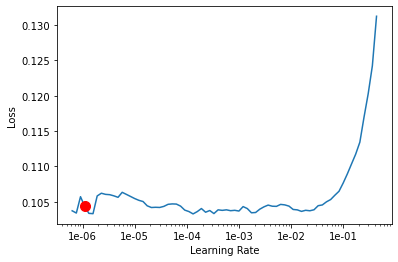

In [53]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
learn.load(base_dir / "learn" / "bigearth-res50-r-1")

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Non-irrigated arable land;Pastures;Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leaved forest,Non-irrigated arable land;Pastures;Complex cultivation patterns;Coniferous forest;Mixed forest,Discontinuous urban fabric;Non-irrigated arable land,Non-irrigated arable land;Complex cultivation patterns;Broad-leaved forest,Land principally occupied by agriculture, with significant areas of natural vegetation;Coniferous forest;Mixed forest;Water bodies
Path: /home/jovyan/Land-Cls/data/bigearth;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leave

In [15]:
learn.fit_one_cycle(10, max_lr=slice(1e-06, 1e-03))
learn.save(base_dir / "learn" / "bigearth-res50-r-2")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.103641,0.097246,0.944315,0.705104,0.779208,21:36
1,0.107196,0.096369,0.944690,0.706461,0.779877,21:30
2,0.105223,0.097364,0.944795,0.706793,0.780167,21:31
3,0.104653,0.099764,0.943425,0.704230,0.781719,21:29
4,0.104422,0.095847,0.944201,0.707255,0.783186,21:30
5,0.104025,0.095971,0.945687,0.710154,0.781752,21:29
6,0.105282,0.095954,0.943950,0.705789,0.781605,21:32
7,0.102089,0.095543,0.944259,0.706607,0.782321,21:31
8,0.104669,0.095215,0.944398,0.707682,0.783751,21:36
9,0.104015,0.094948,0.943915,0.707304,0.785033,21:34


## 2.3. ResNet101

### With Pretraining

In [29]:
arch = models.resnet101

learn = create_multi_cls_learner(data, arch)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jovyan/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [30]:
learn.fit_one_cycle(15, 5e-02)
learn.save(base_dir / "learn" / "bigearth-res101-1")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.098445,0.092179,0.947758,0.719604,0.791340,29:15
1,0.111949,0.109748,0.951230,0.703759,0.743892,29:23
2,0.128353,0.945243,0.934833,0.638576,0.686570,28:38
3,0.134022,0.855405,0.930287,0.611419,0.671951,28:55
4,0.134227,4250.166504,0.865541,0.437460,0.455015,28:50
5,0.133638,0.217897,0.912400,0.572360,0.662716,29:03
6,0.128269,1.123405,0.924756,0.612638,0.687715,28:53
7,0.125802,0.309465,0.928172,0.632200,0.714575,28:59
8,0.122222,0.240854,0.940693,0.663179,0.718601,29:03
9,0.118475,0.247602,0.932586,0.662400,0.747079,28:31


epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-06


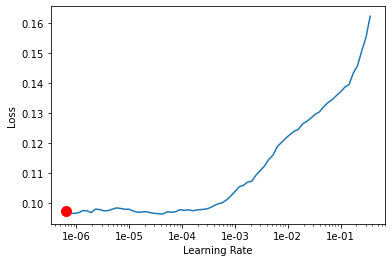

In [31]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 5e-04))
learn.save(base_dir / "learn" / "bigearth-res101-2")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.099108,0.098055,0.950957,0.731106,0.794439,35:20
1,0.097497,0.104052,0.949605,0.725577,0.788959,35:25
2,0.095496,0.089230,0.952466,0.738158,0.800188,35:30
3,0.094765,0.093468,0.953534,0.744282,0.806092,35:29
4,0.092869,0.085189,0.952437,0.743635,0.812167,35:31
5,0.092591,0.085783,0.952304,0.743610,0.811477,35:33
6,0.090505,0.084451,0.953736,0.749209,0.815840,35:35
7,0.087405,0.086302,0.954890,0.753189,0.815848,35:36
8,0.088473,0.084974,0.954804,0.754215,0.819834,35:35
9,0.087789,0.085281,0.955028,0.754782,0.818403,35:32


### Without Pretraining

In [16]:
arch = models.resnet101

learn = create_multi_cls_learner(data, arch, pretrained=False)

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


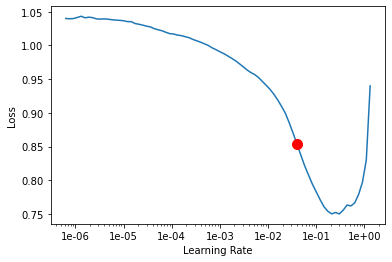

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(15, 5e-02)
learn.save(base_dir / "learn" / "bigearth-res101-r-1")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.132807,1.371684,0.911486,0.499281,0.559772,35:43
1,0.125469,1222.087280,0.876308,0.314737,0.318985,35:34
2,0.137244,134.494324,0.902538,0.511122,0.585099,35:28
3,0.140171,337942.656250,0.426193,0.089384,0.151771,35:30
4,0.149529,8.587247,0.894935,0.438453,0.483991,35:32
5,0.140360,321.508057,0.555688,0.148210,0.213387,35:27
6,0.163487,876.798645,0.879239,0.493044,0.595514,35:33
7,0.145429,0.199617,0.917398,0.507065,0.551705,35:23
8,0.148461,12717.714844,0.402507,0.172726,0.279435,35:27
9,0.151509,1.794541,0.878007,0.379321,0.423436,35:28


epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.91E-05


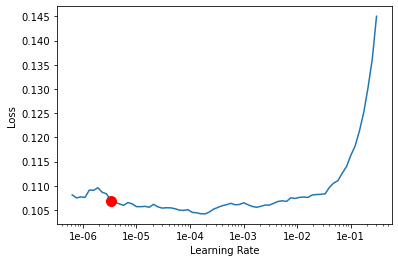

In [19]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 1e-03))
learn.save(base_dir / "learn" / "bigearth-res101-r-2")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.104861,0.099112,0.944091,0.703185,0.776253,35:18
1,0.107043,0.098537,0.941837,0.697211,0.775933,35:24
2,0.106270,0.097885,0.941328,0.697490,0.779245,35:31
3,0.104491,0.100998,0.944102,0.704786,0.779827,35:25
4,0.104590,0.102691,0.943016,0.702414,0.780251,35:30
5,0.104394,0.106574,0.945064,0.706205,0.778016,35:33
6,0.106462,0.099896,0.944292,0.705313,0.778610,35:31
7,0.103846,0.099660,0.944527,0.706555,0.781559,35:34
8,0.105795,0.098159,0.943988,0.705861,0.781032,35:36
9,0.103488,0.097345,0.943460,0.703492,0.780538,35:26


## 2.4. ResNet152

In [33]:
arch = models.resnet152

learn = create_multi_cls_learner(data, arch)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(15, 5e-02)
learn.save(base_dir / "learn" / "bigearth-res152-1")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.100398,0.095624,0.948497,0.721167,0.784030,41:04
1,0.109231,1.195500,0.939970,0.687004,0.755850,41:00
2,0.120141,2.543308,0.937101,0.677336,0.746120,40:57
3,0.127269,1.814089,0.944696,0.660800,0.689334,40:50
4,0.133281,0.148752,0.935854,0.620905,0.675234,40:48


### Without Pretraining

In [25]:
arch = models.resnet152

learn = create_multi_cls_learner(data, arch, pretrained=False)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


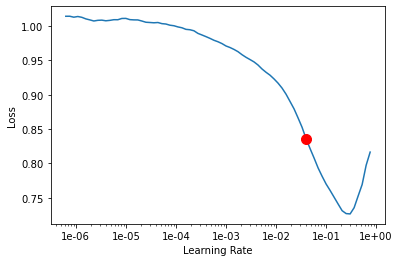

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(15, 5e-02)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125978,2440.798828,0.928634,0.624870,59:49
1,0.125471,4861.031738,0.911844,0.560977,59:16
2,0.139694,6587.037109,0.805013,0.428707,59:08
3,0.140240,2418.294434,0.618160,0.300314,59:10
4,0.140995,3738.331787,0.672918,0.174542,59:05
5,0.154391,2012947456.000000,0.704029,0.312036,59:15
6,0.146944,80.903961,0.876582,0.155352,59:15
7,0.147852,55.921764,0.819961,0.363807,59:11
8,0.139457,0.145025,0.931512,0.596381,59:05
9,0.137269,0.459407,0.917317,0.681617,59:21


In [40]:
learn.save(base_dir / "learn" / "bigearth-res152-test")

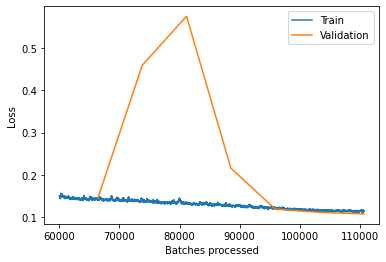

In [43]:
learn.recorder.plot_losses(60000)

In [26]:
learn.load(base_dir / "learn" / "bigearth-res152-test")

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Non-irrigated arable land;Pastures;Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leaved forest,Non-irrigated arable land;Pastures;Complex cultivation patterns;Coniferous forest;Mixed forest,Discontinuous urban fabric;Non-irrigated arable land,Non-irrigated arable land;Complex cultivation patterns;Broad-leaved forest,Land principally occupied by agriculture, with significant areas of natural vegetation;Coniferous forest;Mixed forest;Water bodies
Path: /home/jovyan/Land-Cls/data/bigearth;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leave

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.91E-03


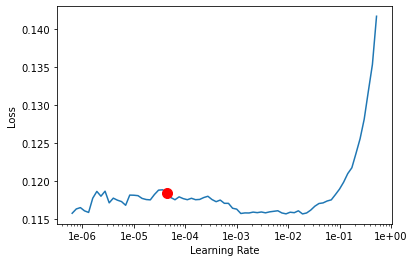

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
learn.fit_one_cycle(10, max_lr = slice(1e-04, 1e-02))
learn.save(base_dir / "learn" / "bigearth-res152-r-2")

epoch,train_loss,valid_loss,accuracy_thresh,f1_score,f2_score,time
0,0.118794,0.109212,0.935240,0.666989,0.748811,51:36
1,0.117268,0.117093,0.935958,0.658566,0.731858,51:44
2,0.120557,0.142606,0.934585,0.655692,0.734565,51:41


KeyboardInterrupt: 